In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lastversion/metadata_COVID.csv
/kaggle/input/lastversion/metadata_NORMAL.csv
/kaggle/input/lastversion/metadata_PNEUMONIA.csv
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_15_0103_02.jpg
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0195_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0012_02.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0849_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_08_0092_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_13_0031_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_01_0034_01.jpg
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0242_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0197_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0379_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_01_0602_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous

In [2]:
!pip install pydicom


In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import pydicom as dicom
from PIL import Image
import PIL
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize, Lambda, Resize
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
class SmokerDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None, labeled=True):
        self.transforms = transforms
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load the image
        file_name = str(self.df['filename'].iloc[idx])
        file_path = f"/kaggle/input/lastversion/clean_data/clean_data/{file_name}"
        
        if file_name.endswith(".dcm"):
            dicom_img = dicom.dcmread(file_path)
            new_img = dicom_img.pixel_array
            scaled_image = (np.maximum(new_img, 0) / new_img.max()) * 255.0
            scaled_image = np.uint8(scaled_image)
            img = Image.fromarray(scaled_image)
        else:
            img = Image.open(file_path).convert("RGB")  

        if self.transforms:
            img = self.transforms(img)

        label = dict_label.get(self.df['smoke'].iloc[idx], -1) 

        return img, label


In [5]:
dict_label={'Yes':1, 'No':0}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
df_normal = pd.read_csv('/kaggle/input/lastversion/metadata_NORMAL.csv')
df_covid = pd.read_csv('/kaggle/input/lastversion/metadata_COVID.csv') 
df_pneumon = pd.read_csv('/kaggle/input/lastversion/metadata_PNEUMONIA.csv') 

In [8]:
df = pd.DataFrame(pd.concat([df_covid, df_normal, df_pneumon], axis=0))
df = df.reset_index(drop=True)

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        4809 non-null   object 
 1   filename      4809 non-null   object 
 2   patient_id    4809 non-null   int64  
 3   hospital      4809 non-null   object 
 4   hospital_eng  4809 non-null   object 
 5   hospital_id   4809 non-null   int64  
 6   sex           2658 non-null   object 
 7   age           2723 non-null   float64
 8   smoke         823 non-null    object 
 9   smoke_number  160 non-null    float64
 10  class         4809 non-null   object 
 11  class_id      4809 non-null   int64  
 12  quality       4809 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 488.5+ KB


In [10]:
import os
import pandas as pd
path = '/kaggle/input/lastversion/clean_data/clean_data/'
files_in_directory = set(os.listdir(path))
df = df[df['filename'].isin(files_in_directory)]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        4230 non-null   object 
 1   filename      4230 non-null   object 
 2   patient_id    4230 non-null   int64  
 3   hospital      4230 non-null   object 
 4   hospital_eng  4230 non-null   object 
 5   hospital_id   4230 non-null   int64  
 6   sex           2413 non-null   object 
 7   age           2477 non-null   float64
 8   smoke         820 non-null    object 
 9   smoke_number  159 non-null    float64
 10  class         4230 non-null   object 
 11  class_id      4230 non-null   int64  
 12  quality       4230 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 429.7+ KB


In [11]:
labeled_df = df[pd.isna(df['smoke']) == False].reset_index(drop=True)  
unlabeled_df = df[pd.isna(df['smoke']) == True].reset_index(drop=True) 

print("Labeled Dataset Info:")
print(labeled_df.info())
print("\nUnlabeled Dataset Info:")
print(unlabeled_df.info())

Labeled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        820 non-null    object 
 1   filename      820 non-null    object 
 2   patient_id    820 non-null    int64  
 3   hospital      820 non-null    object 
 4   hospital_eng  820 non-null    object 
 5   hospital_id   820 non-null    int64  
 6   sex           808 non-null    object 
 7   age           817 non-null    float64
 8   smoke         820 non-null    object 
 9   smoke_number  159 non-null    float64
 10  class         820 non-null    object 
 11  class_id      820 non-null    int64  
 12  quality       820 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 83.4+ KB
None

Unlabeled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 13 columns):
 #   Column        Non-Null 

In [12]:

labeled_df = df[pd.isna(df['smoke']) == False].reset_index(drop=True) 
labeled_train, labeled_test = train_test_split(labeled_df, test_size=0.2, random_state=42)
labeled_train=labeled_train.reset_index(drop=True)
labeled_test=labeled_test.reset_index(drop=True)

unlabeled_df = df[pd.isna(df['smoke']) == True].reset_index(drop=True) 

print("Labeled Trai Dataset Info:")
print(labeled_train.info())
print("\nUnlabeled Dataset Info:")
print(unlabeled_df.info())

Labeled Trai Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        656 non-null    object 
 1   filename      656 non-null    object 
 2   patient_id    656 non-null    int64  
 3   hospital      656 non-null    object 
 4   hospital_eng  656 non-null    object 
 5   hospital_id   656 non-null    int64  
 6   sex           646 non-null    object 
 7   age           654 non-null    float64
 8   smoke         656 non-null    object 
 9   smoke_number  121 non-null    float64
 10  class         656 non-null    object 
 11  class_id      656 non-null    int64  
 12  quality       656 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 66.8+ KB
None

Unlabeled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 13 columns):
 #   Column        Non-

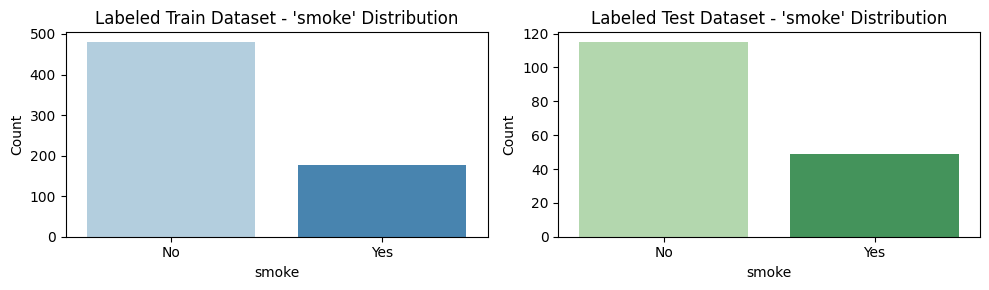

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
sns.countplot(data=labeled_train, x='smoke', palette='Blues')
plt.title("Labeled Train Dataset - 'smoke' Distribution")
plt.xlabel('smoke')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(data=labeled_test, x='smoke', palette='Greens')
plt.title("Labeled Test Dataset - 'smoke' Distribution")
plt.xlabel('smoke')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import pydicom as dicom
import numpy as np
import time

CONFIDENCE_THRESHOLD = 0.9 
UNLABELED_LOSS_WEIGHT = 1.0  
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-4
IMG_SIZE = 224
NUM_CLASSES = 2 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def ensure_rgb(image):
    if isinstance(image, torch.Tensor):
        if image.shape[0] == 1:  
            image = image.repeat(3, 1, 1)
        return image
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image

init_tr = transforms.Compose([
    transforms.Lambda(ensure_rgb),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

init_str = transforms.Compose([
    transforms.Lambda(ensure_rgb),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(contrast=0.3),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

class SmokerDataset(Dataset):
    def __init__(self, df, weak_transforms=None, strong_transforms=None, labeled=True):
        self.df = df
        self.weak_transforms = weak_transforms
        self.strong_transforms = strong_transforms
        self.labeled = labeled

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = str(self.df['filename'].iloc[idx])
        file_path = f"/kaggle/input/lastversion/clean_data/clean_data/{file_name}"

        if file_name.endswith(".dcm"):
            dicom_img = dicom.dcmread(file_path)
            new_img = dicom_img.pixel_array
            scaled_image = (np.maximum(new_img, 0) / new_img.max()) * 255.0
            scaled_image = np.uint8(scaled_image)
            img = Image.fromarray(scaled_image)
        else:
            img = Image.open(file_path).convert("RGB")

        if self.labeled:
            label = dict_label.get(self.df['smoke'].iloc[idx], -1)
            if self.weak_transforms:
                img = self.weak_transforms(img)
            return img, label
        else:
            weak_img = self.weak_transforms(img) if self.weak_transforms else img
            strong_img = self.strong_transforms(img) if self.strong_transforms else img
            return weak_img, strong_img

labeled_df = df[pd.isna(df['smoke']) == False].reset_index(drop=True)
labeled_train, labeled_test = train_test_split(labeled_df, test_size=0.2, random_state=42)
labeled_train = labeled_train.reset_index(drop=True)
labeled_test = labeled_test.reset_index(drop=True)

unlabeled_df = df[pd.isna(df['smoke']) == True].reset_index(drop=True)

labeled_ds = SmokerDataset(labeled_train, weak_transforms=init_tr, labeled=True)
labeled_test_ds = SmokerDataset(labeled_test, weak_transforms=init_tr, labeled=True)

unlabeled_ds = SmokerDataset(
    unlabeled_df, weak_transforms=init_tr, strong_transforms=init_str, labeled=False
)

labeled_loader = DataLoader(labeled_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
labeled_test_loader = DataLoader(labeled_test_ds, batch_size=BATCH_SIZE, shuffle=False)

def unlabeled_collate_fn(batch):
    weak_imgs = torch.stack([item[0] for item in batch])
    strong_imgs = torch.stack([item[1] for item in batch])
    return (weak_imgs, strong_imgs), None

unlabeled_loader = DataLoader(
    unlabeled_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=unlabeled_collate_fn, drop_last=True
)

class FixMatchModel(nn.Module):
    def __init__(self):
        super(FixMatchModel, self).__init__()
        self.model = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
        self.model.classifier[3] = nn.Linear(in_features=1280, out_features=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

def fixmatch_loss(weak_logits, strong_logits, targets, class_weights):
    supervised_loss = nn.CrossEntropyLoss(weight=class_weights)(weak_logits, targets)
    pseudo_probs = torch.softmax(weak_logits.detach(), dim=-1)
    pseudo_labels = pseudo_probs.argmax(dim=-1)
    mask = (pseudo_probs.max(dim=-1).values >= CONFIDENCE_THRESHOLD).float()
    unsupervised_loss = (
        nn.CrossEntropyLoss(reduction="none")(strong_logits, pseudo_labels) * mask
    ).mean()
    return supervised_loss + UNLABELED_LOSS_WEIGHT * unsupervised_loss

scaler = torch.amp.GradScaler()

def train_fixmatch(model, labeled_loader, unlabeled_loader, optimizer, scheduler, epoch, class_weights):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)

    for batch_idx in range(min(len(labeled_loader), len(unlabeled_loader))):
        try:
            labeled_data = next(labeled_iter)
            unlabeled_data = next(unlabeled_iter)
        except StopIteration:
            break

        (labeled_imgs, labels) = labeled_data
        (weak_imgs, strong_imgs), _ = unlabeled_data

        labeled_imgs, labels = labeled_imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        weak_imgs, strong_imgs = weak_imgs.to(DEVICE, non_blocking=True), strong_imgs.to(DEVICE, non_blocking=True)

        with torch.amp.autocast(device_type='cuda'):
            labeled_logits = model(labeled_imgs)
            weak_logits = model(weak_imgs)
            strong_logits = model(strong_imgs)
            loss = fixmatch_loss(labeled_logits, strong_logits, labels, class_weights)

        total_loss += loss.item()
        _, preds = labeled_logits.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

    print(f"[Epoch {epoch + 1}/{EPOCHS}] Loss: {total_loss / len(labeled_loader):.4f}, "
          f"Accuracy: {100 * correct / total:.2f}%, Time: {time.time() - start_time:.2f}s")

class_weights = torch.tensor([0.2, 0.8], device=DEVICE)
model = FixMatchModel().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in range(EPOCHS):
    train_fixmatch(model, labeled_loader, unlabeled_loader, optimizer, scheduler, epoch, class_weights)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 138MB/s] 


[Epoch 1/25] Loss: 0.6762, Accuracy: 35.31%, Time: 251.53s
[Epoch 2/25] Loss: 0.6568, Accuracy: 32.34%, Time: 203.99s
[Epoch 3/25] Loss: 0.6368, Accuracy: 45.47%, Time: 189.44s
[Epoch 4/25] Loss: 0.6040, Accuracy: 50.78%, Time: 202.84s
[Epoch 5/25] Loss: 0.5948, Accuracy: 52.34%, Time: 199.23s
[Epoch 6/25] Loss: 0.5680, Accuracy: 62.03%, Time: 190.97s
[Epoch 7/25] Loss: 0.5331, Accuracy: 68.12%, Time: 181.84s
[Epoch 8/25] Loss: 0.5225, Accuracy: 71.56%, Time: 186.74s
[Epoch 9/25] Loss: 0.4933, Accuracy: 76.56%, Time: 188.33s
[Epoch 10/25] Loss: 0.4993, Accuracy: 78.12%, Time: 187.09s
[Epoch 11/25] Loss: 0.4844, Accuracy: 80.94%, Time: 192.83s
[Epoch 12/25] Loss: 0.4874, Accuracy: 83.28%, Time: 177.80s
[Epoch 13/25] Loss: 0.5561, Accuracy: 85.00%, Time: 182.23s
[Epoch 14/25] Loss: 0.4826, Accuracy: 88.91%, Time: 181.71s
[Epoch 15/25] Loss: 0.4925, Accuracy: 89.69%, Time: 180.65s
[Epoch 16/25] Loss: 0.5856, Accuracy: 91.09%, Time: 183.53s
[Epoch 17/25] Loss: 0.5900, Accuracy: 91.25%, Tim


Classification Report:
              precision    recall  f1-score   support

 Non-Smokers       0.77      0.89      0.83       115
     Smokers       0.59      0.39      0.47        49

    accuracy                           0.74       164
   macro avg       0.68      0.64      0.65       164
weighted avg       0.72      0.74      0.72       164


Confusion Matrix:
[[102  13]
 [ 30  19]]


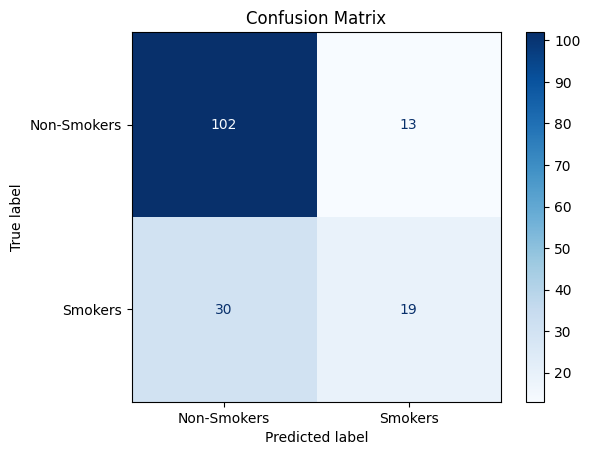

Test Accuracy: 73.78%


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_with_metrics(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = 100 * correct / total

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Non-Smokers", "Smokers"]))

    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Smokers", "Smokers"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy

accuracy = evaluate_with_metrics(model, labeled_test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")